In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import pickle
from sklearn.preprocessing import StandardScaler


In [2]:
# Load the data
train_data = pd.read_csv('aggregated_data_train.csv')
test_data = pd.read_csv('aggregated_data_test.csv')

# Drop the first column
train_data = train_data.drop(columns=['HH_ID'])
test_data = test_data.drop(columns=['HH_ID'])

# Display basic information
print("Training data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Display first few rows of training data
train_data.head()

Training data shape: (209396, 53)
Test data shape: (52350, 53)


,Sector,State,NSS-Region,District,Household Type,Religion of the head of the household,Social Group of the head of the household,HH Size (For FDQ),NCO_3D,NIC_5D,...,mean_age,dependency_ratio,count_married,max_education,count_internet_users,total_meals_school,total_meals_employer,total_meals_payment,total_meals_home,total_meals_others
0,1,21,213,6,6,1,1,2,931.0,41001.0,...,55.000000,0.00,2.0,4.0,0.0,0.0,0.0,0.0,180.0,0.0
1,2,19,193,11,1,1,9,1,522.0,56101.0,...,46.000000,0.00,0.0,5.0,0.0,0.0,0.0,0.0,60.0,0.0
2,2,15,151,3,2,3,1,5,411.0,84119.0,...,29.600000,0.20,2.0,12.0,5.0,0.0,0.0,42.0,408.0,0.0
3,1,12,121,9,1,6,9,6,611.0,1252.0,...,24.166667,0.75,2.0,6.0,4.0,40.0,0.0,0.0,500.0,0.0
4,2,29,293,18,9,1,3,2,963.0,1110.0,...,61.500000,0.00,2.0,7.0,1.0,0.0,0.0,6.0,174.0,0.0


In [3]:
# Separate features and target variable
X_train = train_data.drop(['TotalExpense'], axis=1)
y_train = train_data['TotalExpense']

X_test = test_data.drop(['TotalExpense'], axis=1)
y_test = test_data['TotalExpense']

# apply log transformation to target variable
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Check if there are any missing values
print("Missing values in training features:", X_train.isnull().sum().sum())
print("Missing values in test features:", X_test.isnull().sum().sum())

# Create LightGBM datasets
train_dataset = lgb.Dataset(X_train, label=y_train_log)
test_dataset = lgb.Dataset(X_test, label=y_test_log, reference=train_dataset)

Missing values in training features: 0
Missing values in test features: 0


In [ ]:
# Set LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 500,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'verbose': 1
}

# Train the model
print("Training LightGBM model...")
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=5000,
    valid_sets=[train_dataset, test_dataset],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

# Make predictions with time
import time
start = time.time()
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_train = np.expm1(y_pred_train)
end = time.time()
print("Time taken to make predictions on training data:", end-start)

# Make predictions on test data
start = time.time()
y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_test = np.expm1(y_pred_test)
end = time.time()
print("Time taken to make predictions on test data:", end-start)



Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2418
[LightGBM] [Info] Number of data points in the train set: 209396, number of used features: 52
[LightGBM] [Info] Start training from score 9.764839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[940]	training's rmse: 0.205178	valid_1's rmse: 0.298929


In [49]:
# Evaluate the model
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    print(f"Evaluation on {dataset_name} dataset:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'mape': mape}

# Evaluate on training and test sets
train_metrics = evaluate_model(y_train, y_pred_train, "Training")
test_metrics = evaluate_model(y_test, y_pred_test, "Test")

Evaluation on Training dataset:
MAE: 3253.6743
RMSE: 6524.2141
R²: 0.7776
MAPE: 0.1569
Evaluation on Test dataset:
MAE: 4738.7323
RMSE: 8701.2076
R²: 0.5933
MAPE: 0.2309


<Figure size 1200x800 with 0 Axes>

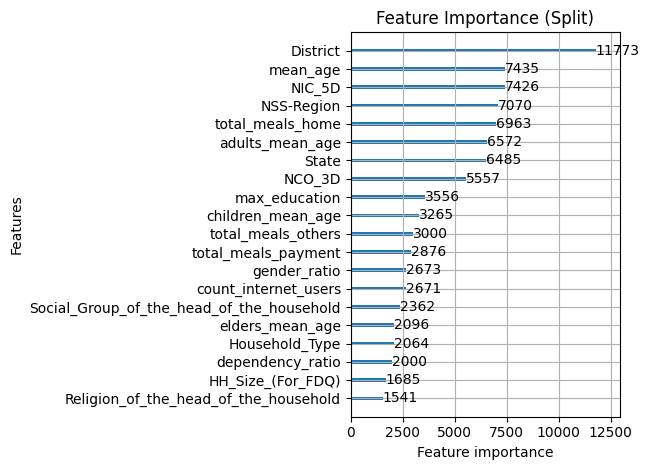

<Figure size 1200x800 with 0 Axes>

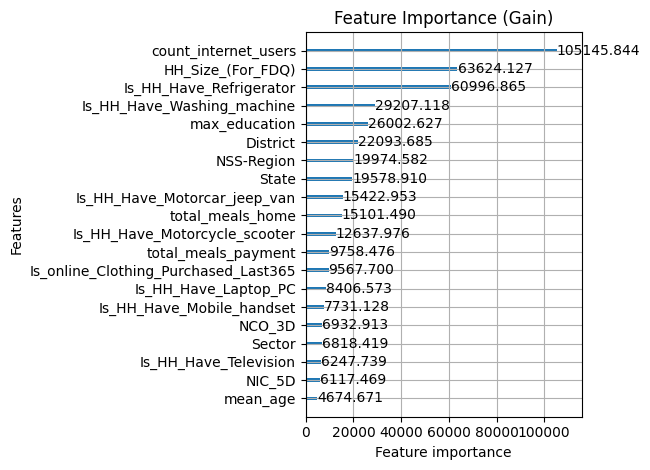

In [6]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=20, importance_type='split')
plt.title('Feature Importance (Split)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.tight_layout()
plt.show()

In [7]:
# Save the feature importance to a CSV file
importance = pd.DataFrame({
    'Feature': model.feature_name(),
    'Importance': model.feature_importance(importance_type='gain')
})
importance = importance.sort_values('Importance', ascending=False)
importance.to_csv('lightgbm_feature_importance.csv', index=False)

# Save the model
model.save_model('lightgbm_model.txt')
print("Model saved to 'lightgbm_model.txt'")

Model saved to 'lightgbm_model.txt'


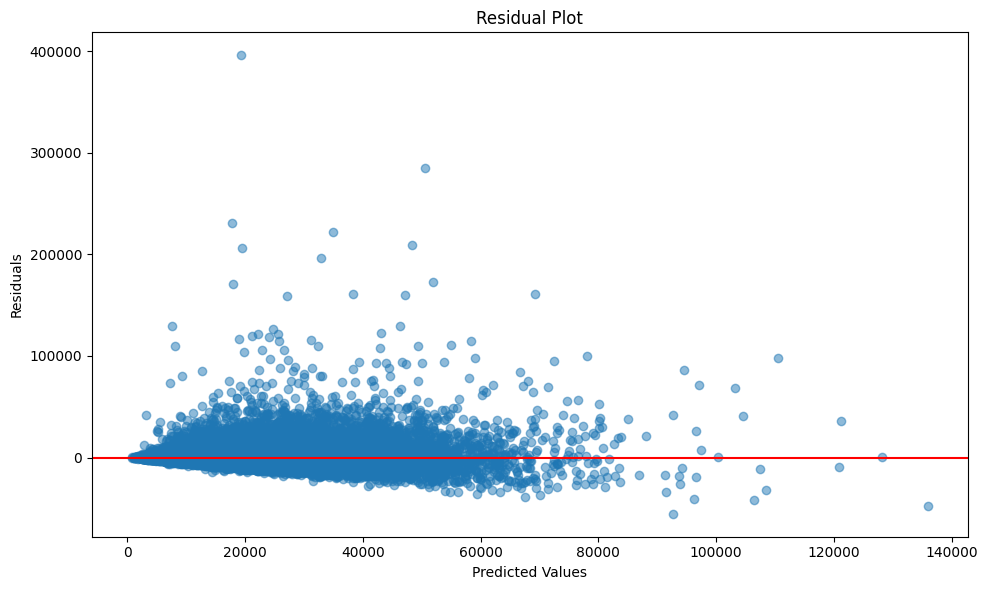

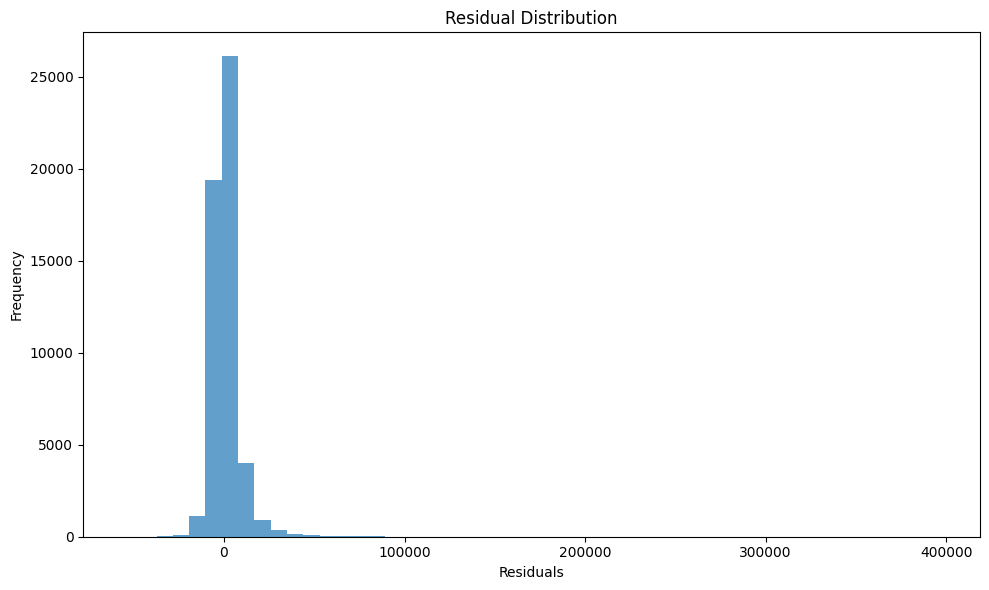

In [8]:
# Analyze residuals
residuals_test = y_test - y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=50, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.show()

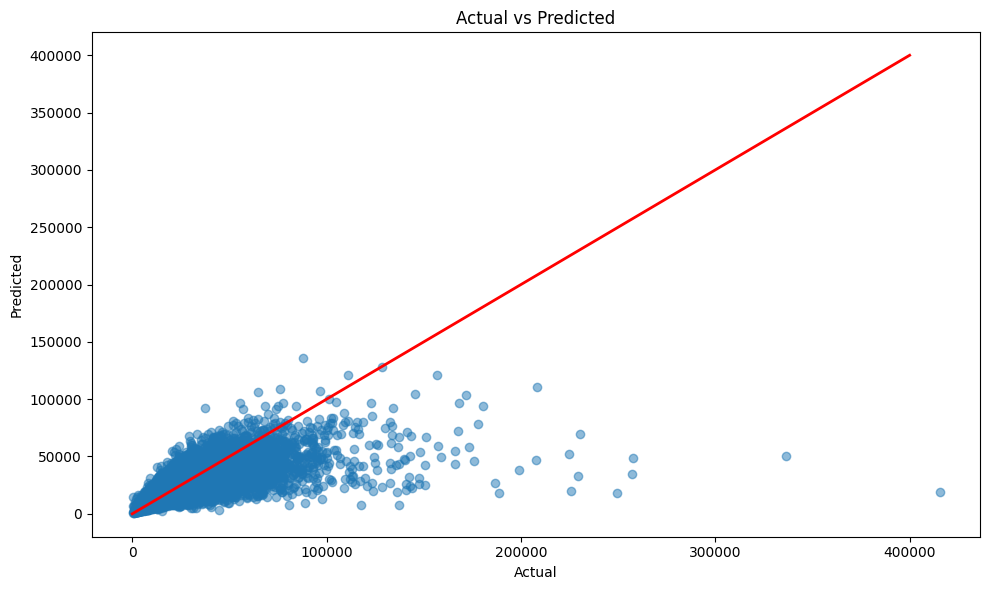

In [12]:
# plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([0, 400000], [0, 400000], color='red', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.show()